# Climbing logs: exploration

Exploration of the usability of the logs

### 0. Variables and dependencies

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt

In [2]:
from climb.extraction import extract_climbinglogs, extract_sessionlogs
from climb.aggregation import compute_gradepyramid_basic, get_maxgrade_flash, get_mediangrade, compute_gradepyramid
from climb.diagram import plot_doublegradepyramid, plot_gradepyramid

In [3]:
filein = './data/climbinglogs.xlsx'

### 1. Read in the data

In [4]:
from climb.grade import import_gradestable

In [5]:
logs = extract_climbinglogs(filein,
                            cols_ffill=['date', 'climbing_gym', 'grade']
                           )

In [6]:
logs

,date,climbing_gym,climbing_sequence_in_session,route,grade,ascension_type,style,route_information,blocks,falls,sends,notes,grade_usa,grade_french
0,2022-10-27,"Allez-up, Montreal",1.0,NaN,5.9,redpoint,lead,NaN,0,0,1,NaN,5.9,5b
1,2022-10-27,"Allez-up, Montreal",2.0,NaN,5.10b,flash,lead,Roof,0,0,1,NaN,5.10b,6a
2,2022-10-27,"Allez-up, Montreal",3.0,NaN,5.10c,redpoint,lead,Arrete,0,0,1,NaN,5.10c,6a+
3,2022-10-27,"Allez-up, Montreal",4.0,62 - yellow,5.11d,redpoint,lead,NaN,0,0,1,1st lead,5.11d,7a
4,2022-10-27,"Allez-up, Montreal",5.0,NaN,5.10d,flash,lead,Roof,0,0,1,NaN,5.10d,6b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,2022-12-08,"Allez-up, Montreal",NaN,42 - yellow,5.10d,repeat,lead,NaN,0,0,1,NaN,5.10d,6b
175,2022-12-08,"Allez-up, Montreal",NaN,13 - yellow,5.11a,redpoint,lead,sloper,0,0,1,NaN,5.11a,6b+
176,2022-12-08,"Allez-up, Montreal",NaN,23 - black,5.12b,topped,lead,NaN,1,0,1,fell just after crux,5.12b,7b
177,2022-12-08,"Allez-up, Montreal",NaN,52 - orange,5.11c,flash,lead,NaN,0,0,1,NaN,5.11c,6c+


### 2. Create a route pyramid

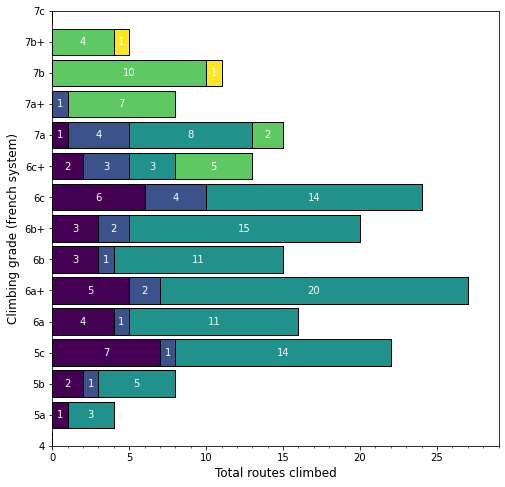

In [7]:
fig = plot_gradepyramid(logs, aggtype='sum', gradesystem='french')

Text(12, 7a, '')

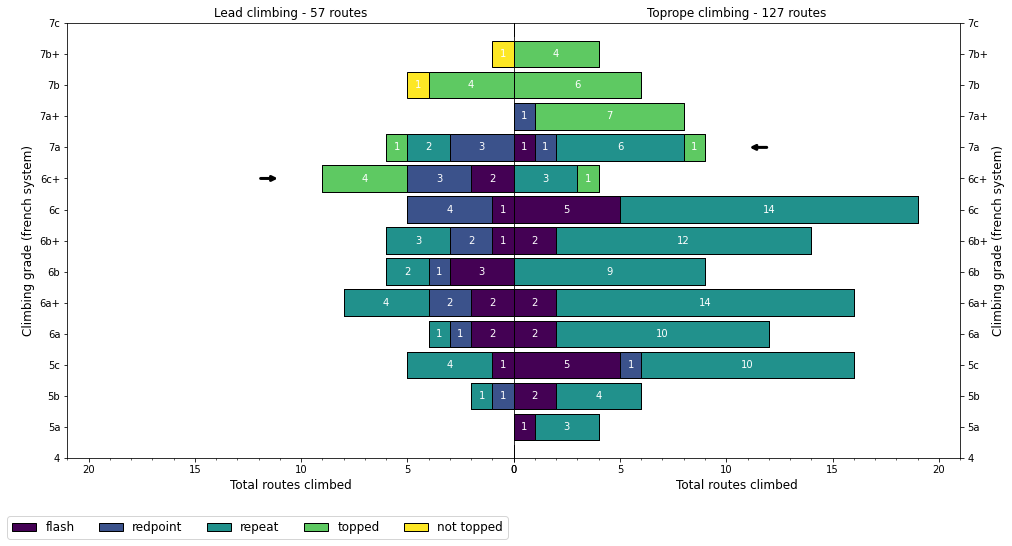

In [8]:
fig = plot_doublegradepyramid(logs, aggtype='sum', gradesystem='french')
ax1, ax2 = fig.get_axes()

ax1.annotate("", 
             xy=(11, get_maxgrade_flash(logs[logs['style'] == 'lead'], gradesystem='french')),
             xytext=(12, get_maxgrade_flash(logs[logs['style'] == 'lead'], gradesystem='french')),
             arrowprops=dict(arrowstyle="->", lw=3))
ax2.annotate("", 
             xy=(11, get_maxgrade_flash(logs[logs['style'] == 'toprope'], gradesystem='french')),
             xytext=(12, get_maxgrade_flash(logs[logs['style'] == 'toprope'], gradesystem='french')),
             arrowprops=dict(arrowstyle="->", lw=3))

In [9]:
temp = logs['grade_french'].sort_values().to_list()
if len(temp) % 2 == 0:
    print(temp[int((len(temp)) / 2)])
else:
    print(temp[int((len(temp) + 1) / 2)])

6c


In [10]:
logs['week'] = logs['date'].dt.isocalendar().week

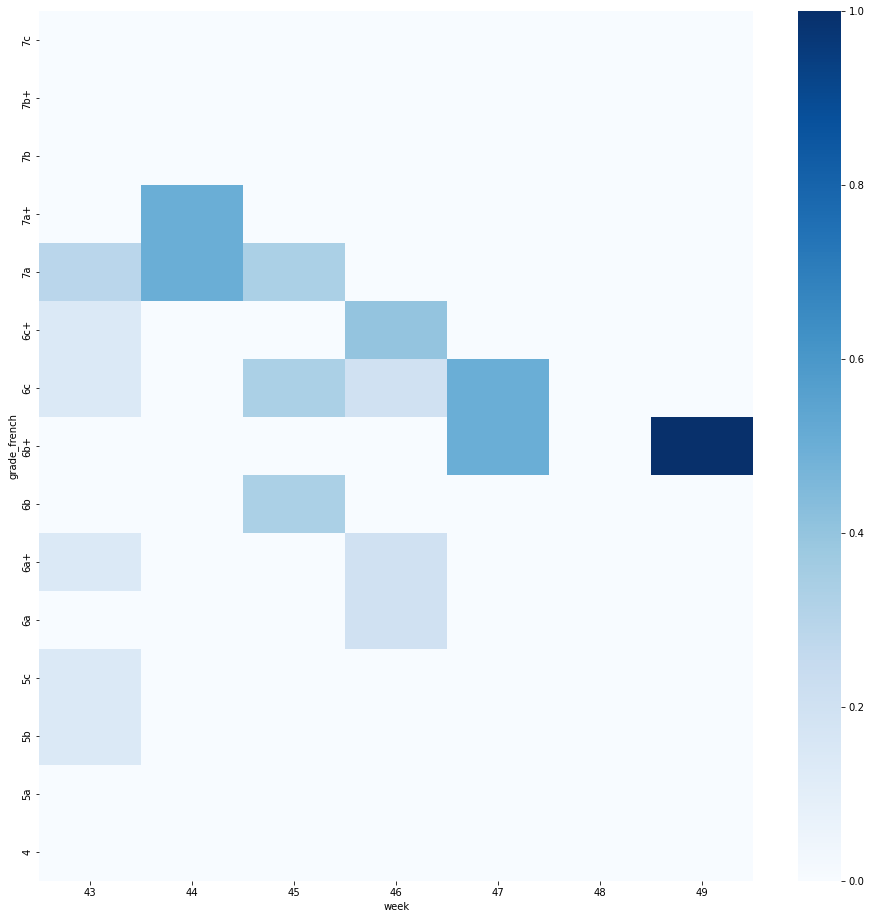

In [11]:
pyrm = (logs[logs['ascension_type'] == 'redpoint']
        .groupby(['week', 'grade_french'])
        .agg(sends=('sends', 'sum'),
            )
       )

temp = (logs[logs['ascension_type'] == 'redpoint']
        .groupby('week')
        .agg(sends_total=('sends', 'sum'),
            )
       )

# Join the two dataframes
pyrm = pyrm.reset_index()
temp = temp.reset_index()

pyrm = pyrm.merge(temp, on=['week'], how='left')

pyrm['sends_percentage'] = pyrm['sends'] / pyrm['sends_total']
pyrm.loc[:, 'sends_percentage'] = pyrm.loc[:, 'sends_percentage'].fillna(0.)

# Perform pivot
pyrm = pyrm.pivot(index='grade_french', columns='week', values='sends_percentage')

pyrm = pyrm.drop(index=['1', '2', '3', 
                        '7c+', '8a', '8a+', '8b',
                       ])

pyrm

import seaborn as sns

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
sns.heatmap(pyrm, cmap='Blues', ax=ax)
ax.invert_yaxis()

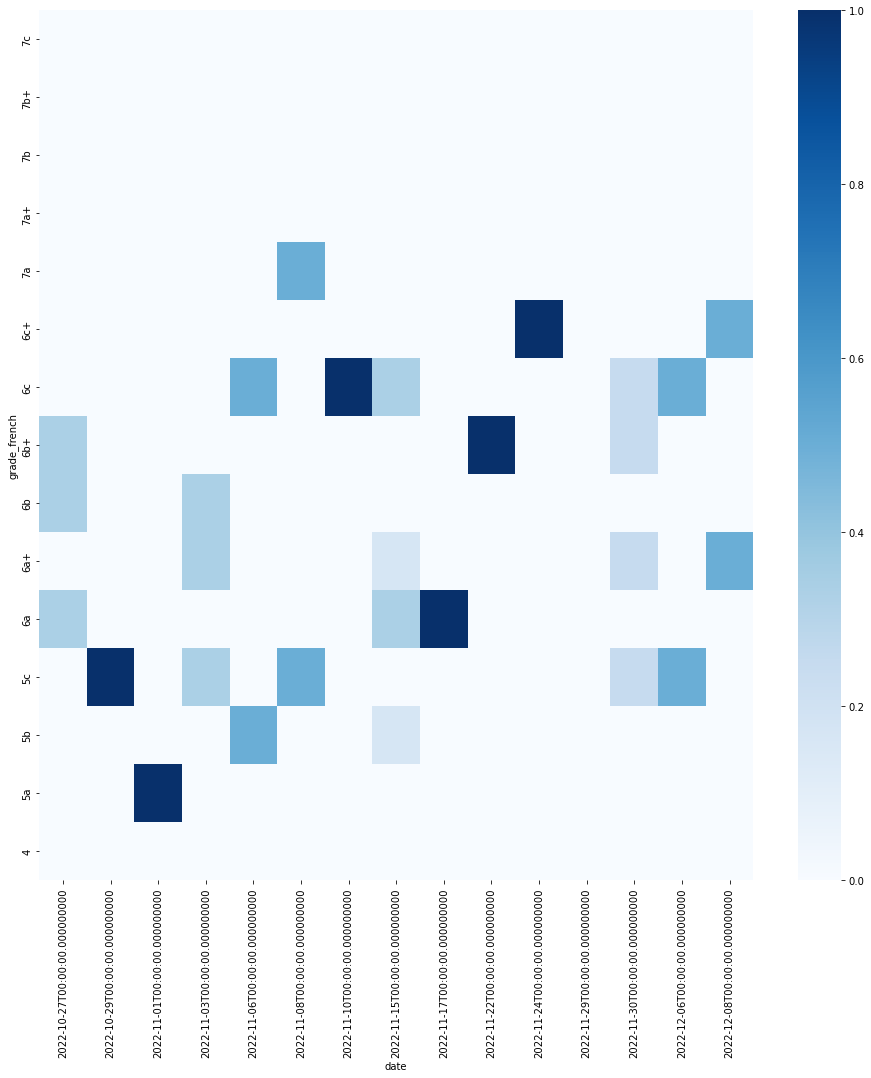

In [12]:
pyrm = (logs[logs['ascension_type'] == 'flash']
        .groupby(['date', 'grade_french'])
        .agg(sends=('sends', 'sum'),
            )
       )

temp = (logs[logs['ascension_type'] == 'flash']
        .groupby('date')
        .agg(sends_total=('sends', 'sum'),
            )
       )

# Join the two dataframes
pyrm = pyrm.reset_index()
temp = temp.reset_index()

pyrm = pyrm.merge(temp, on=['date'], how='left')

pyrm['sends_percentage'] = pyrm['sends'] / pyrm['sends_total']
pyrm.loc[:, 'sends_percentage'] = pyrm.loc[:, 'sends_percentage'].fillna(0.)

# Perform pivot
pyrm = pyrm.pivot(index='grade_french', columns='date', values='sends_percentage')

pyrm = pyrm.drop(index=['1', '2', '3', 
                        '7c+', '8a', '8a+', '8b',
                       ])

pyrm

import seaborn as sns

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
sns.heatmap(pyrm, cmap='Blues', ax=ax)
ax.invert_yaxis()

In [13]:
from matplotlib import rc, rcParams
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator, FixedLocator, FixedFormatter
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc("lines", markeredgewidth=2.0)
rc("axes", linewidth=2.0)
rc('font', family='serif')
rcParams["font.size"] = 15
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'out'

In [14]:
pyrm

date,2022-10-27,2022-10-29,2022-11-01,2022-11-03,2022-11-06,2022-11-08,2022-11-10,2022-11-15,2022-11-17,2022-11-22,2022-11-24,2022-11-29,2022-11-30,2022-12-06,2022-12-08
grade_french,,,,,,,,,,,,,,,
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0
5a,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0
5b,0.000000,0.0,0.0,0.000000,0.5,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.00,0.0,0.0
5c,0.000000,1.0,0.0,0.333333,0.0,0.5,0.0,0.000000,0.0,0.0,0.0,0.0,0.25,0.5,0.0
6a,0.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,1.0,0.0,0.0,0.0,0.00,0.0,0.0
6a+,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.25,0.0,0.5
6b,0.333333,0.0,0.0,0.333333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0
6b+,0.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.25,0.0,0.0
6c,0.000000,0.0,0.0,0.000000,0.5,0.0,1.0,0.333333,0.0,0.0,0.0,0.0,0.25,0.5,0.0


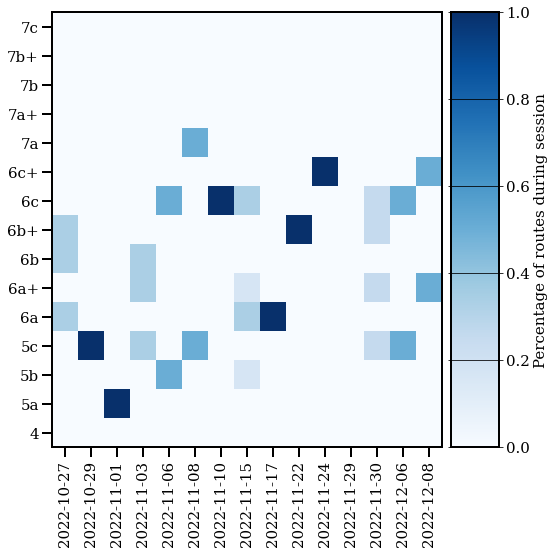

In [15]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(1, 8, width_ratios=[1,1,1,1,1,1,1,1])
ax = fig.add_subplot(gs[0,:7])
axcb = fig.add_axes(gs[0,7].get_position(fig))

pos = ax.imshow(pyrm.values, cmap='Blues', interpolation='none', aspect='auto', origin='lower')

cbar = fig.colorbar(pos, cax=axcb, format='%1.1f')
cbar.set_label('Percentage of routes during session')

ax.xaxis.set_major_locator(FixedLocator([ii for ii in range(pyrm.shape[1])]))
ax.yaxis.set_major_locator(FixedLocator([ii for ii in range(pyrm.shape[0])]))
ax.set_xticklabels([val.strftime('%Y-%m-%d') for val in pyrm.columns.to_list()],
                   rotation=90)
ax.set_yticklabels(pyrm.index.to_list())
ax.tick_params(axis='both',which='major',length=10,width=2)

axcb.grid(color='k')
axcb.tick_params(left='on')

In [16]:
temp

,date,sends_total
0,2022-10-27,3
1,2022-10-29,2
2,2022-11-01,1
3,2022-11-03,6
4,2022-11-06,2
5,2022-11-08,2
6,2022-11-10,1
7,2022-11-15,6
8,2022-11-17,1
9,2022-11-22,1


In [17]:
logs[logs['grade_french'] == '7b+']

,date,climbing_gym,climbing_sequence_in_session,route,grade,ascension_type,style,route_information,blocks,falls,sends,notes,grade_usa,grade_french,week
25,2022-11-01,"Allez-up, Montreal",5.0,NaN,5.12c,topped,toprope,NaN,0,6,1,Had to skip one move,5.12c,7b+,44
70,2022-11-12,"Allez-up, Montreal",6.0,72 - blue,5.12c,not topped,lead,roof,0,2,1,NaN,5.12c,7b+,45
77,2022-11-13,"Allez-up, Montreal",4.0,61 - black,5.12c,topped,toprope,NaN,1,0,1,NaN,5.12c,7b+,45
106,2022-11-19,"Allez-up, Montreal",7.0,32 - purple,5.12c,topped,toprope,roof,2,2,1,NaN,5.12c,7b+,46
168,2022-12-06,"Allez-up, Montreal",5.0,32 - purple,5.12c,topped,toprope,NaN,6,0,1,NaN,5.12c,7b+,49


C:\Users\bramb\AppData\Local\Temp\ipykernel_21372\3719329739.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


Text(0.5, 0, 'Week number')

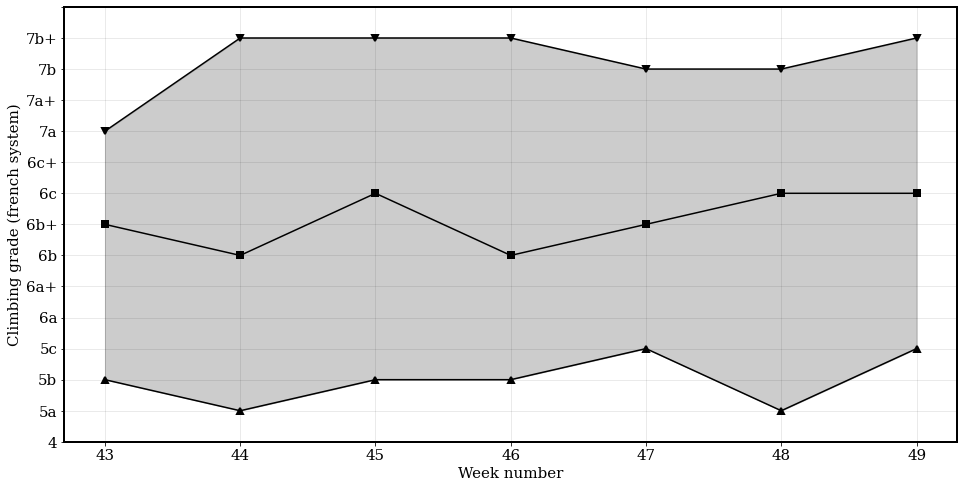

In [18]:
cond = (logs['ascension_type'] != 'not topped') & (logs['style'] != 'boulder') & (logs['style'] != 'autobelay')
temp = logs[cond]
temp = (pd.DataFrame(temp.values.repeat(temp.sends,
                                        axis=0),
                     columns=temp.columns
                    )
        .astype(temp.dtypes)
       )
temp = temp.groupby('week').agg(maxgrade=('grade_french', 'max'),
                                mediangrade=('grade_french', get_mediangrade),
                                mingrade=('grade_french', 'min'),
                               )


import json
with open('./climb/grades.json') as ff:
    grades = json.load(ff)['french2usa']
grade_map = {kk:vv for kk, vv in zip(grades.keys(), range(len(grades)))}

temp['maxgrade_int'] = [grade_map[val] for val in temp['maxgrade']]
temp['mediangrade_int'] = [grade_map[val] for val in temp['mediangrade']]
temp['mingrade_int'] = [grade_map[val] for val in temp['mingrade']]


from matplotlib.ticker import FormatStrFormatter, MultipleLocator

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.plot(temp.index, temp['maxgrade_int'], 'k-v')
ax.plot(temp.index, temp['mediangrade_int'], 'k-s')
ax.plot(temp.index, temp['mingrade_int'], 'k-^')
ax.fill_between(temp.index.to_list(), temp['mingrade_int'].values, temp['maxgrade_int'].values, color='k', alpha=.2)

# Determine min and max of the grades plotted
grade_plotmin = temp.loc[:, ['maxgrade', 'mediangrade', 'mingrade']].min().min()
grade_plotmax = temp.loc[:, ['maxgrade', 'mediangrade', 'mingrade']].max().max()

# Determine the list of labels
grade_invmap = {vv:kk for kk, vv in grade_map.items()}
labels = [grade_invmap[vv] for vv in range(grade_map[grade_plotmin] - 2, grade_map[grade_plotmax] + 1, 1)]
# WARNING
# Need to determine why this is -2, instead of -1

ax.set_ylim([grade_map[grade_plotmin] - 1, 
             grade_map[grade_plotmax] + 1
            ])
             
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_yticklabels(labels)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.grid(color='k', alpha=.1)
ax.set_ylabel('Climbing grade (french system)')
ax.set_xlabel('Week number')



In [19]:
cond = (logs['ascension_type'] != 'not topped') & (logs['style'] != 'boulder') & (logs['style'] != 'autobelay')
temp = logs[cond]
temp = (pd.DataFrame(temp.values.repeat(temp.sends,
                                        axis=0),
                     columns=temp.columns
                    )
        .astype(temp.dtypes)
       )
temp = temp.groupby('week').agg(maxgrade=('grade_french', 'max'),
                                mediangrade=('grade_french', get_mediangrade),
                                mingrade=('grade_french', 'min'),
                               )


import json
with open('./climb/grades.json') as ff:
    grades = json.load(ff)['french2usa']
grade_map = {kk:vv for kk, vv in zip(grades.keys(), range(len(grades)))}

temp['maxgrade_int'] = [grade_map[val] for val in temp['maxgrade']]
temp['mediangrade_int'] = [grade_map[val] for val in temp['mediangrade']]
temp['mingrade_int'] = [grade_map[val] for val in temp['mingrade']]
temp

,maxgrade,mediangrade,mingrade,maxgrade_int,mediangrade_int,mingrade_int
week,,,,,,
43,7a,6b+,5b,13,10,5
44,7b+,6b,5a,16,9,4
45,7b+,6c,5b,16,11,5
46,7b+,6b,5b,16,9,5
47,7b,6b+,5c,15,10,6
48,7b,6c,5a,15,11,4
49,7b+,6c,5c,16,11,6


In [20]:
cond = (logs['ascension_type'] == 'flash') & (logs['style'] != 'boulder') & (logs['style'] != 'autobelay')
temp = logs[cond]
temp = (pd.DataFrame(temp.values.repeat(temp.sends,
                                        axis=0),
                     columns=temp.columns
                    )
        .astype(temp.dtypes)
       )
temp = temp.groupby('week').agg(maxgrade=('grade_french', 'max'),
                                mediangrade=('grade_french', get_mediangrade),
                                mingrade=('grade_french', 'min'),
                               )


import json
with open('./climb/grades.json') as ff:
    grades = json.load(ff)['french2usa']
grade_map = {kk:vv for kk, vv in zip(grades.keys(), range(len(grades)))}

temp['maxgrade_int'] = [grade_map[val] for val in temp['maxgrade']]
temp['mediangrade_int'] = [grade_map[val] for val in temp['mediangrade']]
temp['mingrade_int'] = [grade_map[val] for val in temp['mingrade']]
temp

,maxgrade,mediangrade,mingrade,maxgrade_int,mediangrade_int,mingrade_int
week,,,,,,
43,6b+,6b,5c,10,9,6
44,6c,6b,5a,11,9,4
45,7a,7a,5c,13,13,6
46,6c,6a+,5b,11,8,5
47,6c+,6c+,6b+,12,12,10
48,6c,6b+,5c,11,10,6
49,6c+,6c,5c,12,11,6


In [21]:
cond = (logs['ascension_type'] == 'redpoint') & (logs['style'] != 'boulder') & (logs['style'] != 'autobelay')
temp = logs[cond]
temp = (pd.DataFrame(temp.values.repeat(temp.sends,
                                        axis=0),
                     columns=temp.columns
                    )
        .astype(temp.dtypes)
       )
temp = temp.groupby('week').agg(maxgrade=('grade_french', 'max'),
                                mediangrade=('grade_french', get_mediangrade),
                                mingrade=('grade_french', 'min'),
                               )


import json
with open('./climb/grades.json') as ff:
    grades = json.load(ff)['french2usa']
grade_map = {kk:vv for kk, vv in zip(grades.keys(), range(len(grades)))}

temp['maxgrade_int'] = [grade_map[val] for val in temp['maxgrade']]
temp['mediangrade_int'] = [grade_map[val] for val in temp['mediangrade']]
temp['mingrade_int'] = [grade_map[val] for val in temp['mingrade']]
temp

IndexError: list index out of range

In [ ]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.errorbar(temp.index, temp['mediangrade_int'],
            yerr=np.vstack((temp['mediangrade_int'] - temp['mingrade_int'], temp['maxgrade_int'] - temp['mediangrade_int'])),
            color='k',
            marker='s',
            ecolor='gray',
            capsize=8,
            capthick=2,
            elinewidth=2,
            ms=14
           )

# Determine min and max of the grades plotted
grade_plotmin = temp.loc[:, ['maxgrade', 'mediangrade', 'mingrade']].min().min()
grade_plotmax = temp.loc[:, ['maxgrade', 'mediangrade', 'mingrade']].max().max()

# Determine the list of labels
grade_invmap = {vv:kk for kk, vv in grade_map.items()}
labels = [grade_invmap[vv] for vv in range(grade_map[grade_plotmin] - 1, grade_map[grade_plotmax] + 2, 1)]

ax.set_ylim([grade_map[grade_plotmin] - 1, 
             grade_map[grade_plotmax] + 1
            ])
             
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_yticklabels(labels)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.grid(color='k', alpha=.1)
ax.set_ylabel('Climbing grade (french system)')
ax.set_xlabel('Week number')